In [1]:
#!pip install catboost
#!pip install -q catboost shap

In [1]:
import pandas as pd # Подключаем библиотеку для работы с данными(нам нужны DataFrime)
import numpy as np

import matplotlib.pyplot as plt # Для визаулизации
import seaborn as sns # Для визуализации

import shap # Для показа статистик

from sklearn.model_selection import train_test_split # Для того чтобы разбивать на подвыборки
from catboost.utils import eval_metric # Вычислите указанную метрику по необработанным приближенным значениям формулы и значениям меток.
from catboost import CatBoostRegressor, Pool # Наш помошник для работы с ML

В первую очередь мы вытащим данные, они у нас предоставлены в виде 2 файлов:train.csv, test.csv

In [2]:
df_train = pd.read_csv('./house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('./house-prices-advanced-regression-techniques/test.csv')

Избавляемся от столбцов содержащих значения параметра NaNи делаем одинаковым количество столбцов

In [3]:
df_train = df_train.dropna(axis=1)
df_test = df_test.dropna(axis=1)

In [4]:
#Выравниваем количество стобцов в тестовой и обчающей выборках
for col in df_train.columns:
    if col not in df_test.columns and col!= "SalePrice":
        del df_train[col]
        
del df_test['Electrical'] # столбец которые присуттвует только в тестовой выборке 
# Параметры в данных столбцах не переводились CatBoost в бинаризованные поэтому было принято решение их уничтожить)(столбцы), так как количество признаков достаточно велико, это сильно не должно скааться на результате предсказания
del df_test['LotShape'], df_train['LotShape']
del df_test['LandContour'], df_train['LandContour']
del df_test['LotConfig'], df_train['LotConfig']
del df_test['SaleCondition'], df_train['SaleCondition']
del df_test['RoofStyle'], df_train['RoofStyle']
del df_test['RoofMatl'], df_train['RoofMatl']
del df_test['Foundation'], df_train['Foundation']
del df_test['CentralAir'], df_train['CentralAir']
#Формируем валидационную выборку из обучающей
df_val = df_train.sample(frac =.20, random_state = 2021)

Убираем из обучающей выборки строки содержащиеся в валидационной выборке, чтобы данные были независимыми

In [6]:
df_Id_val = df_val.Id.values.copy() # интовый список Id
for i in range(len(df_Id_val)): # Делаем из него список строк Id
     df_Id_val[i] = str(df_Id_val[i]-1)#Удаляем Id val выбоки из train выборки
        
print(len(df_val))
print(len(df_train))
df_test['SalePrice'] = 0
#print(df_train.isna().mean().count())
#print(df_test.isna().mean().count())
df_train = df_train.drop(df_Id_val)
print(f"Размер валидационной выборки:{len(df_val)}")
print(f"Размер обучающей выборки:{len(df_train)}")

292
1460
Размер валидационной выборки:292
Размер обучающей выборки:1168


In [7]:
df_test

,Id,MSSubClass,LotArea,Street,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1461,20,11622,Pave,Gtl,NAmes,Feedr,Norm,1Fam,1Story,...,140,0,0,0,120,0,0,6,2010,0
1,1462,20,14267,Pave,Gtl,NAmes,Norm,Norm,1Fam,1Story,...,393,36,0,0,0,0,12500,6,2010,0
2,1463,60,13830,Pave,Gtl,Gilbert,Norm,Norm,1Fam,2Story,...,212,34,0,0,0,0,0,3,2010,0
3,1464,60,9978,Pave,Gtl,Gilbert,Norm,Norm,1Fam,2Story,...,360,36,0,0,0,0,0,6,2010,0
4,1465,120,5005,Pave,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,...,0,82,0,0,144,0,0,1,2010,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,1936,Pave,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,...,0,0,0,0,0,0,0,6,2006,0
1455,2916,160,1894,Pave,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,...,0,24,0,0,0,0,0,4,2006,0
1456,2917,20,20000,Pave,Gtl,Mitchel,Norm,Norm,1Fam,1Story,...,474,0,0,0,0,0,0,9,2006,0
1457,2918,85,10441,Pave,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,...,80,32,0,0,0,0,700,7,2006,0


In [8]:
#определяем фичи, котофичи) и наш предсказываемый параметр
features = list(df_test.columns)[:-1]
cat_features = ['Street', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond', 'Heating', 'HeatingQC', 'Fireplaces', 'PavedDrive', 'PoolArea']
target = 'SalePrice'

#features

Распределение нашей целевой переменной в обучающей выборке

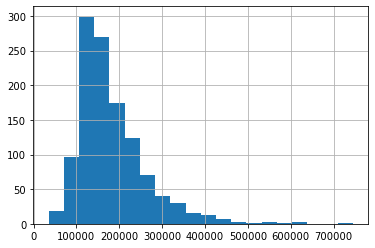

In [9]:
_ = df_train[target].hist(bins=20)

Распределение нашей целевой переменной в валидационнойвыборке

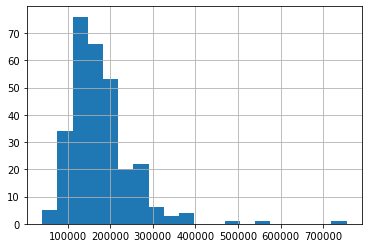

In [10]:
_ = df_val[target].hist(bins=20)

Заносим в Pool

In [11]:
train_pool = Pool(df_train[features], label=df_train[target],
                  cat_features=cat_features)
val_pool = Pool(df_val[features], label=df_val[target],
                 cat_features=cat_features)
test_pool = Pool(df_test[features], label=df_test[target],
                 cat_features=cat_features)

Задаём параметры обучения и стартуем

In [12]:
#cb_L = CatBoostRegressor(loss_function='LogLoss', n_estimators=500, silent=True)
#cb_L.fit(train_pool, eval_set=val_pool, plot=True)

cbR = CatBoostRegressor(
                            iterations = 1000,
                            #n_estimators = 2000,
                            task_type='CPU',
                            #task_type='GPU', 
                            silent=True,
                            eval_metric = "RMSE", 
                            #early_stopping_rounds = True
)
cbR.fit(train_pool,
            eval_set=val_pool,
            verbose=500,
            plot=True)

predicted_counts = cbR.predict(test_pool)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.04745
0:	learn: 77736.7636094	test: 74326.0477979	best: 74326.0477979 (0)	total: 187ms	remaining: 3m 6s
500:	learn: 15570.6065492	test: 23286.5154899	best: 23286.5154899 (500)	total: 21.8s	remaining: 21.7s
999:	learn: 10252.6773407	test: 22805.7752962	best: 22805.7752962 (999)	total: 44.4s	remaining: 0us

bestTest = 22805.7753
bestIteration = 999



Запишем результат наших предсказаний в Datafrime и получим файл с предсказанием цен

In [27]:
column_sub1 = (df_test.Id.values).tolist()
column_sub2 = list((predicted_counts))

df_csv = pd.DataFrame(column_sub2,
                index = column_sub1,
               columns = ['SalePrice'])

df_csv.to_csv('submission.csv')

In [17]:
print(cbR.get_test_eval())

[64708.357316759924, 106944.0363917748, 327452.8047006851, 202695.39382329697, 158121.67117312294, 232479.02598407792, 194612.9244140058, 189315.05938749723, 193240.49955704465, 134302.05514801305, 150392.86799936846, 150153.453068835, 157101.10973131933, 188536.7455720648, 97529.37631651308, 266952.4091197531, 172901.23182959, 200348.13532384153, 141981.36430680146, 186554.28221306036, 114632.5074739805, 97911.06354015319, 259682.50365452038, 111772.0470859452, 344291.3140241875, 82287.02390468224, 127684.11845047226, 169600.58644337993, 257587.9126203818, 151035.04028135215, 132527.93410663054, 122816.08545645788, 220930.5874367319, 138338.8363209228, 187412.35032702456, 98087.5344794894, 205529.72452330525, 121143.19060719917, 150070.90541796113, 209080.70420002553, 191785.765280453, 121339.0158455507, 154447.40164656777, 190337.02375778568, 186032.9712332825, 173943.60584511797, 141072.60754082704, 316060.03165297443, 173223.41577444764, 216450.86910093034, 180840.92471164322, 3284

Считаем основные метрики при помощи библиотеки shap

In [14]:
shap_info = cbR.get_feature_importance(
    data=train_pool, 
    type='ShapValues', 
    verbose=10000
)
shap_values = shap_info[:,:-1]
base_values = shap_info[:,-1]


Processing trees...
128/1000 trees processed	passed time: 68.6ms	remaining time: 467ms
1000/1000 trees processed	passed time: 461ms	remaining time: 0us
Processing documents...
128/1168 documents processed	passed time: 11.4ms	remaining time: 92.5ms
1168/1168 documents processed	passed time: 95.8ms	remaining time: 0us


In [15]:
shap_values.shape

(1168, 38)

Удаляем таргет признак из трейн выборки для просмотра влияния признаков

In [24]:
spap_train = df_train.copy()
del spap_train['SalePrice']

Проанализируем влияние признаков согласно пункту 5

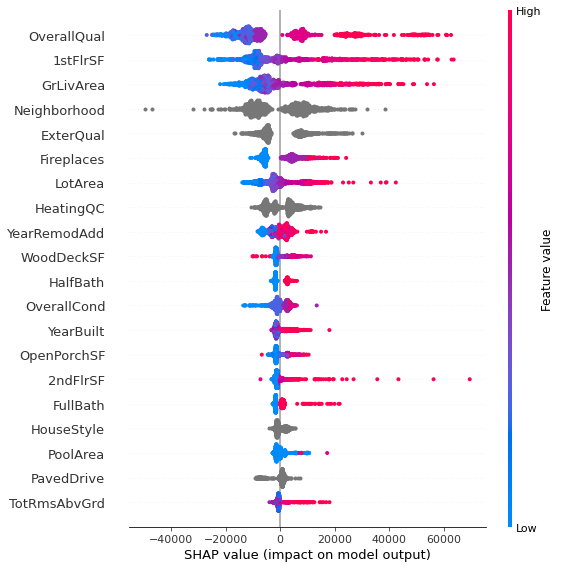

In [25]:
shap.summary_plot(shap_values, spap_train)

Многие признаки которые из логических соображений вносили бы значительный вклад были удалены, при более тщательной фильтрации данных можно добиться лучшего результата и сохранения некоторых признаков. 

При такой модели удалось получить на платформе Kaggle ($Scope: 0.14091$)

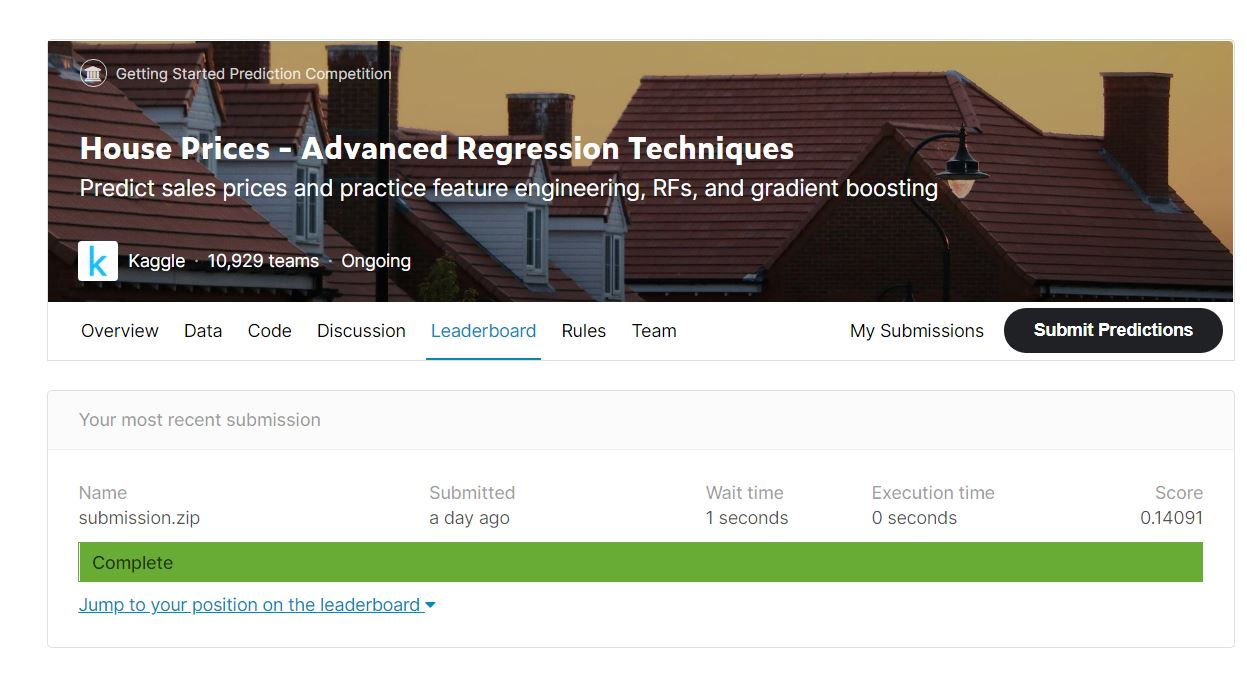

In [29]:
from IPython.display import Image # Скриншот демонстрирующий успешное принятие задания на платформе
Image("Screen.jpg")